In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib widget

import numpy as np
import matplotlib.pylab as plt

from matplotlib import rcParams
rcParams['figure.figsize'] = 15,6

from src import data
!date -I

2023-11-02


In [2]:
import mne
import mne_connectivity as mne_connect
from autoreject import get_rejection_threshold

In [3]:
%ls {data.path('external/annen_tms_eeg_ebrains')}

data-descriptor_a3dade301e9f.pdf  sub-S02/  sub-S05/  sub-S08/  sub-S11/
participants.csv                  sub-S03/  sub-S06/  sub-S09/  sub-S12/
sub-S01/                          sub-S04/  sub-S07/  sub-S10/


In [4]:
data_dir = data.path('external/annen_tms_eeg_ebrains')

In [5]:
raw = mne.io.read_raw_eximia(f"{data_dir}/sub-S01/sub-S01.nxe", preload=False, verbose=None)
raw_data = raw.get_data()
raw.set_montage('standard_1005')
raw.__dict__

Loading sub-S01.nxe


{'preload': False,
 '_last_samps': array([1482441]),
 '_first_samps': array([0]),
 'info': <Info | 8 non-empty values
  bads: []
  ch_names: GateIn, Trig1, Trig2, EOG, Fp1, Fpz, Fp2, AF1, AFz, AF2, F7, F3, ...
  chs: 3 Stimulus, 1 EOG, 60 EEG
  custom_ref_applied: False
  dig: 63 items (3 Cardinal, 60 EEG)
  highpass: 0.0 Hz
  lowpass: 725.0 Hz
  meas_date: unspecified
  nchan: 64
  projs: []
  sfreq: 1450.0 Hz
 >,
 'buffer_size_sec': 1.0,
 '_cals': array([0.0015259 , 0.0015259 , 0.0015259 , 0.38147555, 0.07629511,
        0.07629511, 0.07629511, 0.07629511, 0.07629511, 0.07629511,
        0.07629511, 0.07629511, 0.07629511, 0.07629511, 0.07629511,
        0.07629511, 0.07629511, 0.07629511, 0.07629511, 0.07629511,
        0.07629511, 0.07629511, 0.07629511, 0.07629511, 0.07629511,
        0.07629511, 0.07629511, 0.07629511, 0.07629511, 0.07629511,
        0.07629511, 0.07629511, 0.07629511, 0.07629511, 0.07629511,
        0.07629511, 0.07629511, 0.07629511, 0.07629511, 0.07629511,
   

In [6]:
raw = raw.crop(tmin=200.0, tmax=400.)

In [7]:
events = mne.find_events(raw, stim_channel=["GateIn","Trig1","Trig2"],min_duration = 2 / raw.info['sfreq'])

87 events found
Event IDs: [4]


In [8]:
mapping = {
    4: "trigger",
}
annot_from_events = mne.annotations_from_events(
    events=events,
    event_desc=mapping,
    sfreq=raw.info["sfreq"],
    orig_time=raw.info["meas_date"],
)
raw.set_annotations(annot_from_events)
raw.annotations

/tmp/ipykernel_236017/990441730.py:10: RuntimeWarning: Omitted 87 annotation(s) that were outside data range.
  raw.set_annotations(annot_from_events)


<Annotations | 0 segments>

In [9]:
def plot_evoked(raw, events):
    epochs = mne.Epochs(raw, events, tmin=-0.05, tmax=0.2,  preload=True)
    evoked = epochs.average()
    evoked.plot()

/tmp/ipykernel_236017/3548074359.py:9: RuntimeWarning: Omitted 87 annotation(s) that were outside data range.
  raw.set_annotations(stimulation_annot)


Using matplotlib as 2D backend.


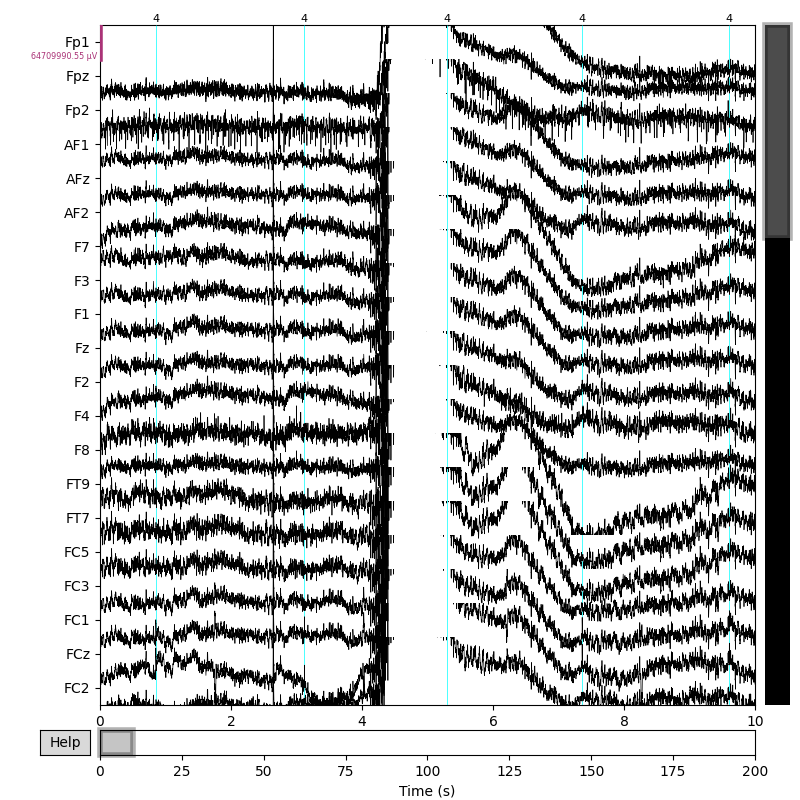

In [10]:
duration_ms = 40 / 1000

onsets = events[:, 0] / raw.info["sfreq"] - duration_ms/2
durations = [duration_ms] * len(events)
descriptions = ["stimulation"] * len(events)
stimulation_annot = mne.Annotations(
    onsets, durations, descriptions, orig_time=raw.info["meas_date"]
)
raw.set_annotations(stimulation_annot)
raw.plot(events=events,scalings='auto');

Not setting metadata
87 matching events found
Setting baseline interval to [-0.0496551724137931, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 87 events and 363 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


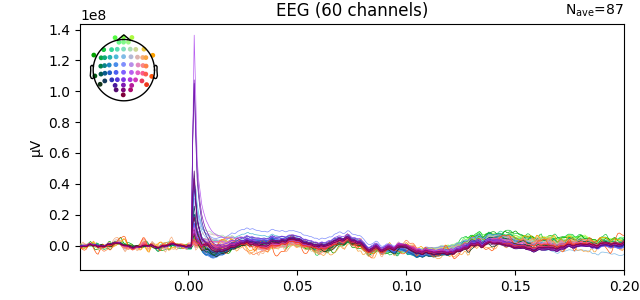

In [11]:
plot_evoked(raw, events)

In [12]:
raw.info["sfreq"]

1450.0

Creating RawArray with float64 data, n_channels=64, n_times=290001
    Range : 290000 ... 580000 =    200.000 ...   400.000 secs
Ready.
Overwriting existing file.
Writing /home/izaak/local_repos/megaloceros/katka_fimuni_thesis/data/external/annen_tms_eeg_ebrains/sub-S01/interpolated-S01-raw.fif
Closing /home/izaak/local_repos/megaloceros/katka_fimuni_thesis/data/external/annen_tms_eeg_ebrains/sub-S01/interpolated-S01-raw.fif
[done]


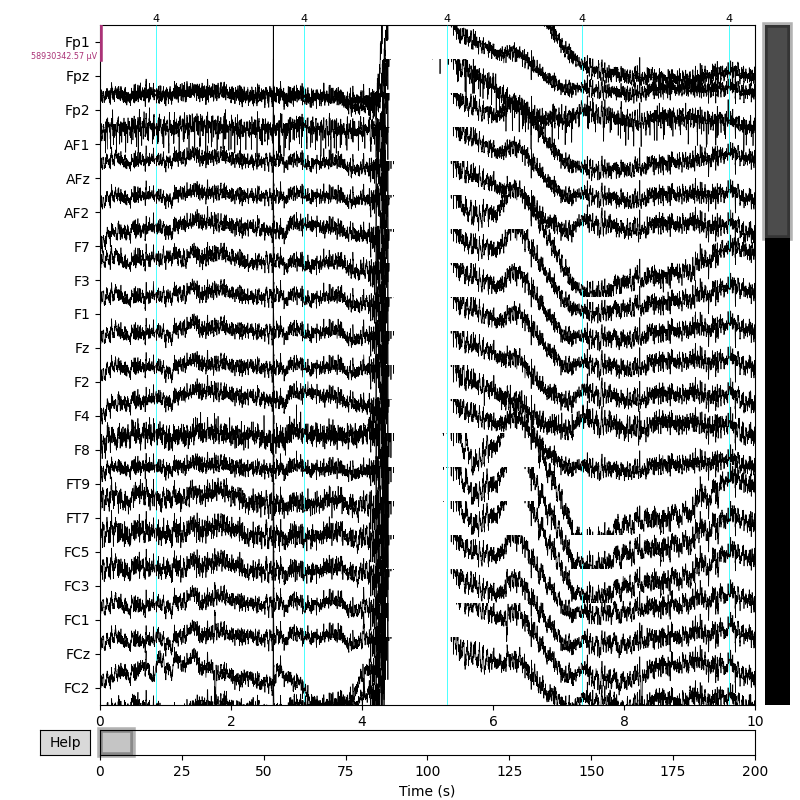

In [13]:
data = raw.get_data()

# %%
event_onset_samples = events[:, 0] - raw.first_samp  # don't forget first_samp!
for event_onset_sample in event_onset_samples:
    samp_start = event_onset_sample - int(raw.info["sfreq"] * 0.01)
    samp_end = event_onset_sample + int(raw.info["sfreq"] * 0.010)
    for d in data:
        d[samp_start:samp_end] = np.interp(list(range(samp_start,samp_end)),[samp_start-1,samp_end],[d[samp_start-1],d[samp_end]])

raw_interpolated = mne.io.RawArray(
    data=data,
    info=raw.info,
    first_samp=raw.first_samp,  # don't forget first_samp!
)

raw_interpolated.save(f'{data_dir}/sub-S01/interpolated-S01-raw.fif', overwrite=True)


raw_interpolated.plot(events=events,scalings='auto');

Not setting metadata
87 matching events found
Setting baseline interval to [-0.0496551724137931, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 87 events and 363 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


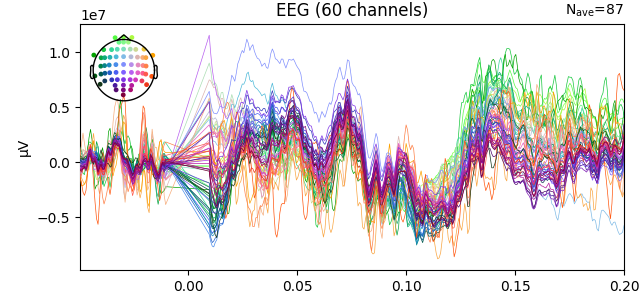

In [14]:
plot_evoked(raw_interpolated, events)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 4785 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Effective window size : 1.412 (s)


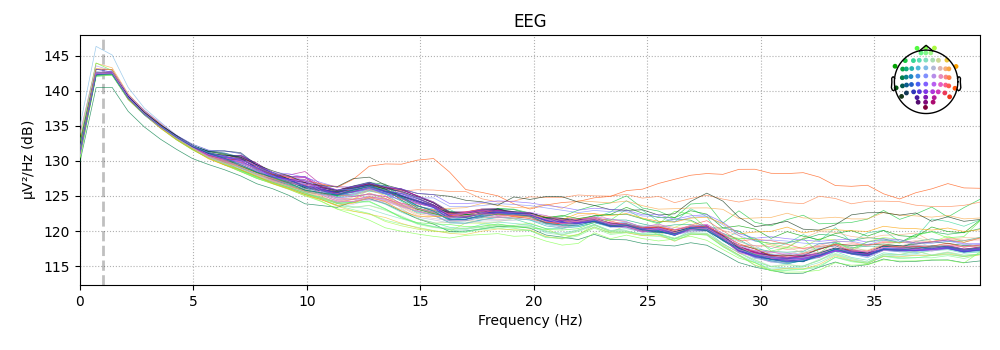

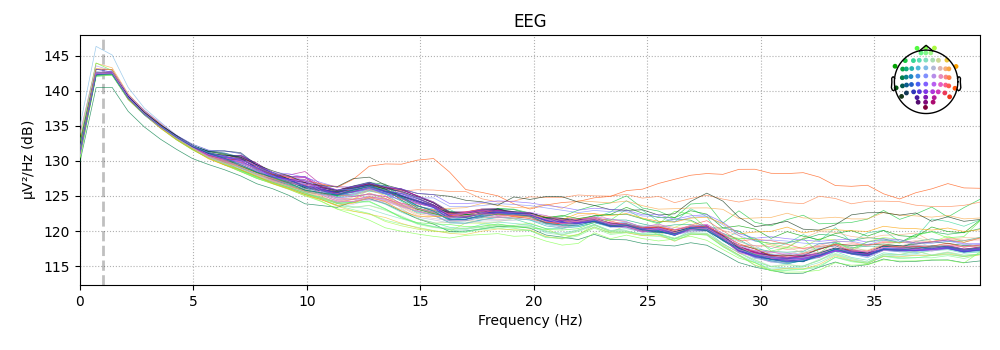

In [15]:
# Filter settings
low_cut = 1.
hi_cut  = 80

raw_filtered = raw_interpolated.filter(low_cut, hi_cut)
raw_filtered.compute_psd(fmax=40).plot();

Not setting metadata
87 matching events found
Setting baseline interval to [-0.0496551724137931, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 87 events and 363 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


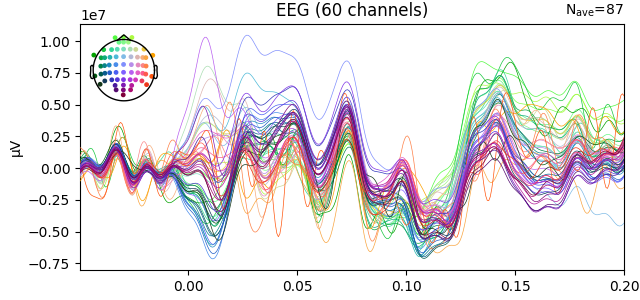

In [16]:
plot_evoked(raw_filtered, events)

In [17]:
raw_filtered.save(f'{data_dir}/sub-S01/interpolated-filtered-S01-raw.fif', overwrite=True)


Overwriting existing file.
Writing /home/izaak/local_repos/megaloceros/katka_fimuni_thesis/data/external/annen_tms_eeg_ebrains/sub-S01/interpolated-filtered-S01-raw.fif
Closing /home/izaak/local_repos/megaloceros/katka_fimuni_thesis/data/external/annen_tms_eeg_ebrains/sub-S01/interpolated-filtered-S01-raw.fif
[done]


In [18]:
# Filter settings
ica_low_cut = 1.0       # For ICA, we filter out more low-frequency power
hi_cut  = 30

raw_ica = raw_interpolated.copy()#.filter(ica_low_cut, hi_cut)


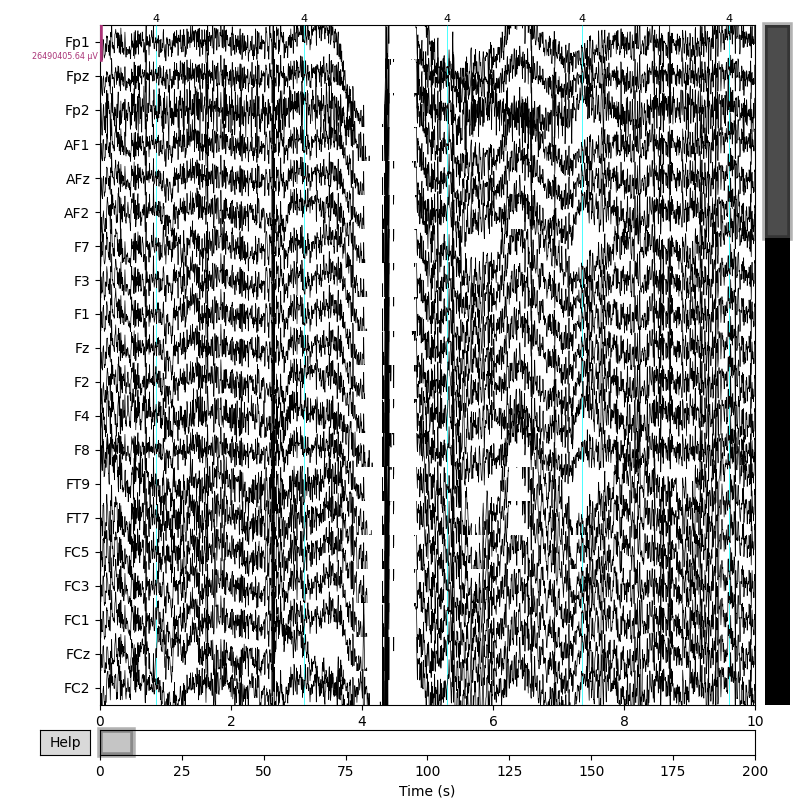

In [19]:
raw_ica.plot(events=events,scalings='auto');

Not setting metadata
87 matching events found
Setting baseline interval to [-0.0496551724137931, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 87 events and 363 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


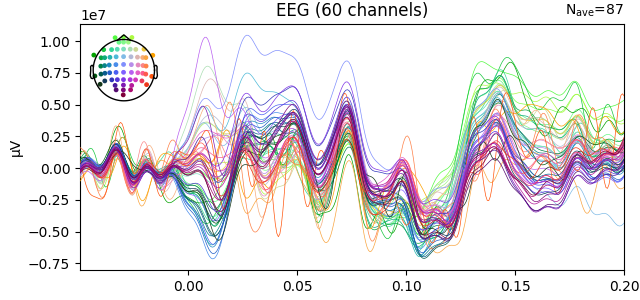

In [20]:
plot_evoked(raw_ica, events)

In [21]:
# Break raw data into 10 s epochs, because 1 s (used in tutorial) needs too much memory 
tstep = 1.0
events_ica = mne.make_fixed_length_events(raw_ica, duration=tstep)
epochs_ica = mne.Epochs(raw_ica, events_ica,
                        tmin=0.0, tmax=tstep,
                        baseline=None,
                        preload=True)



Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 200 events and 1451 original time points ...
0 bad epochs dropped


In [22]:
reject = get_rejection_threshold(epochs=epochs_ica,decim=2,random_state=42);
reject

Estimating rejection dictionary for eeg
Estimating rejection dictionary for eog


{'eeg': 151.41202853173473, 'eog': 156.78644998855572}

In [23]:
# Fit ICA
ica = mne.preprocessing.ICA(n_components=.99, # Specify n_components as a decimal to set % explained variance
                            random_state=42)

ica.fit(epochs_ica,reject=reject)

Fitting ICA to data using 60 channels (please be patient, this may take a while)


/tmp/ipykernel_236017/1067751212.py:5: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  ica.fit(epochs_ica,reject=reject)


Selecting by explained variance: 20 components
Fitting ICA took 14.6s.


<ICA | epochs decomposition, method: fastica (fit in 45 iterations on 290200 samples), 20 ICA components (60 PCA components available), channel types: eeg, no sources marked for exclusion>

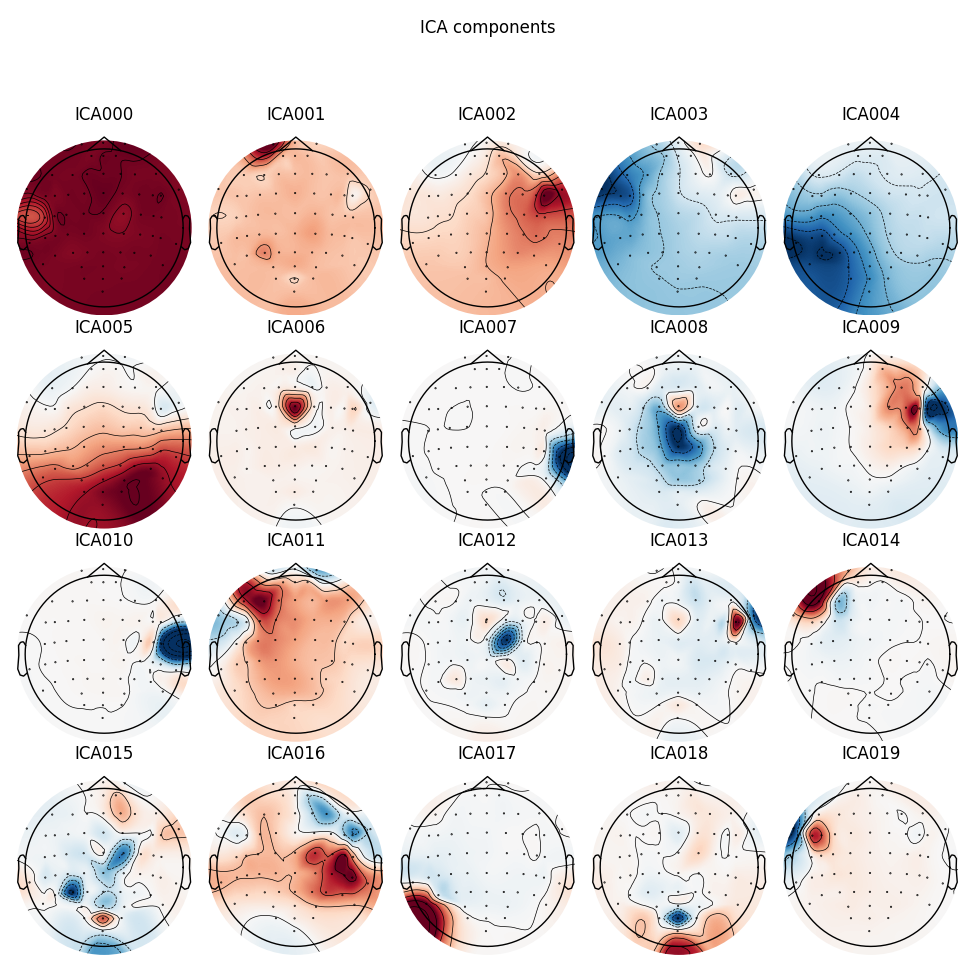

In [24]:
ica.plot_components(); # popisky, co by to mohlo zanmenat: https://neuraldatascience.io/7-eeg/erp_artifacts.html
# výsledný obrázek je v zásadě stejný, jako bez interpolace

Creating RawArray with float64 data, n_channels=21, n_times=290001
    Range : 290000 ... 580000 =    200.000 ...   400.000 secs
Ready.


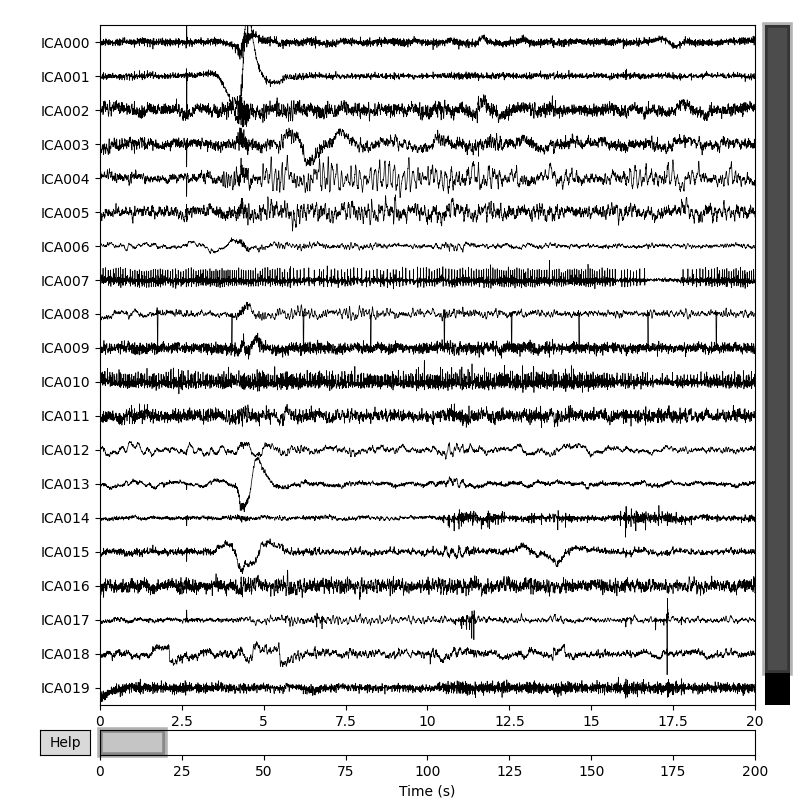

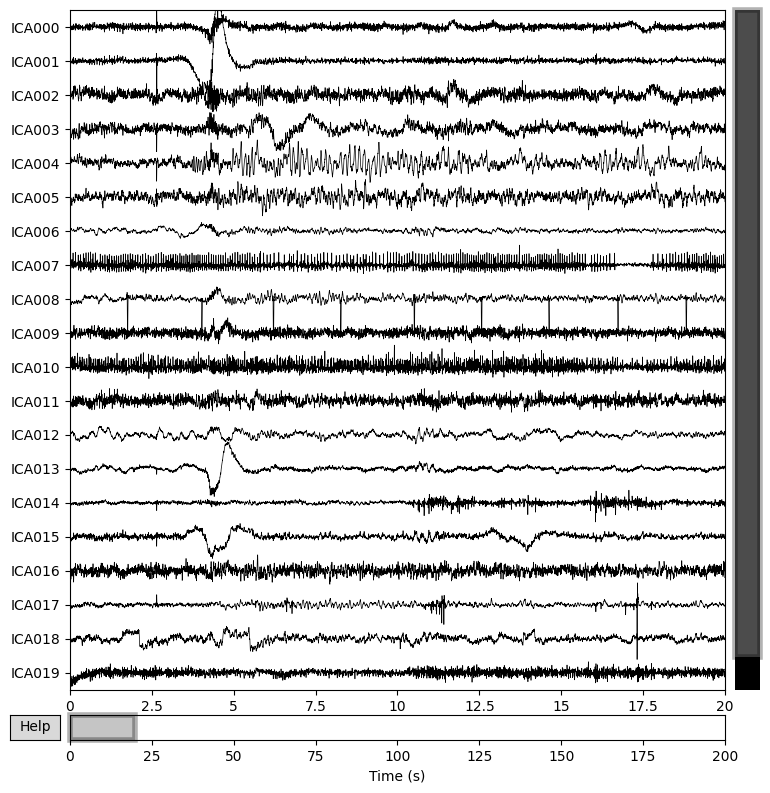

In [25]:
ica.plot_sources(raw_ica, )